# ABOUT THE PROJECT

The objective of the project is to build a segmentation model which can identify defect location on steel surface. For this we have used the open surface defect database from Northeaster University(NEU).

In this database, six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). The images provided in the database are in grayscale and of uniform dimensions 200x200.

The database can be found in the below link:-

http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html

The description of the database in the above url states that the database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects

The defect images are found in the folder named IMAGES. The folder named ANNOTATIONS contains the details of the defect location on each image in xml files.


Before we started with the project we ran the script named **Create _Validation_Images.ipynb**. This script created two folders named Validation_Images and Validation_Annotations. The script randomly selected five images from each class and moved those images and their annotation xmls to the folders Validation_Images and Validation_Annotations respectively. The model training won't be done on the images present in the Validation_Images. These images will be only used for final validation with our model.

## IMPORTS

We made some imports. The class etree from the library xml contains a function called ElementTree which can extract imformation from a xml file. We will see it's use here to extract information about the defects on the image.

In [1]:
import xml.etree.ElementTree as ET
import os
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import albumentations.augmentations.functional as F
%matplotlib inline

## Data Extraction

Let's first initialize two variables with the image and annotations folder path respectively

In [2]:
image_folder = '.\IMAGES'
annot_folder = '.\ANNOTATIONS'

Next let's check how many images and annotations are present.

In [3]:
print(f'Number of Images: {len(os.listdir(image_folder))}') 
print(f'Number of Annotations: {len(os.listdir(annot_folder))}') 

Number of Images: 1770
Number of Annotations: 1770


So there are 1770 images and annotations. This is because we took out 30 images and annotations from the original database for final validation.

Next let's write a function which will create a dataframe that will give a view of which image has which type of defect. The function would require the annotation folder path to give the output. The function will use ElementTree to extract the information from the xml files.  

In [4]:
def create_filepaths(path):
    df = pd.DataFrame()
    for (dirpath, dirnames,filenames) in os.walk(path):
        for filename in filenames:
            temp_path = "\\".join([path, filename])
            tree = ET.parse(temp_path)
            root = tree.getroot()
            dict1 = dict()
            ls = []
            for description in root.iter('name'):
                ls.append(description.text)
            res = np.array(ls)
            res = np.unique(res)
            ls = res.tolist()
            dict1['Name'] = filename[:-4]
            for ele in ls:
                dict1[ele] = 1
            df = df.append(dict1, ignore_index= True)
    df = df.replace(np.nan, 0)
    df['Number_of_Defects'] = df.drop('Name',axis=1).sum(axis=1) 
        
    return df   

In [5]:
df = create_filepaths(annot_folder)
df.head()

,Name,crazing,patches,inclusion,pitted_surface,rolled-in_scale,scratches,Number_of_Defects
0,crazing_1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,crazing_10,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,crazing_100,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,crazing_101,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,crazing_102,1.0,0.0,0.0,0.0,0.0,0.0,1.0


So, from the above result we can see the dataframe has columns named Name, crazing, patches, inclusion, pitted_surface, rolled-in_scale, scratches and Defects. The Name column contains the Name of the Image. The columns crazing, patches, inclusion, pitted_surface, rolled-in_scale and scratches are the defects. So, the function found 6 unique defects which matches with what has been originally mentioned in the project description. The defect columns will have value either 1 or 0. 1 means that defect is present and 0 means that defect is not present in the image. The column Number_of_Defects signify how many types of defects are present against each image.

Next let's check how many unique images are returned by the function in the dataframe.

In [6]:
df['Name'].nunique()

1770

So, from the above result we can see that the dataframe has 1770 unique images. This matches with the number of images in the IMAGES folder. Hence, this proves that the function has been able to read all the images.

In, the upcoming section we will do some extensive data exploration.

## Exploratory Data Analysis

In this section we will analyse the data further. Let's start by looking at the dataframe information.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770 entries, 0 to 1769
Data columns (total 8 columns):
Name                 1770 non-null object
crazing              1770 non-null float64
patches              1770 non-null float64
inclusion            1770 non-null float64
pitted_surface       1770 non-null float64
rolled-in_scale      1770 non-null float64
scratches            1770 non-null float64
Number_of_Defects    1770 non-null float64
dtypes: float64(7), object(1)
memory usage: 110.7+ KB


From the above results it is clear that none of the row has null values and all rows have 1770 entries. Next let's display the dataframe statistics.

In [8]:
df.describe()

,crazing,patches,inclusion,pitted_surface,rolled-in_scale,scratches,Number_of_Defects
count,1770.000000,1770.000000,1770.000000,1770.000000,1770.000000,1770.000000,1770.000000
mean,0.166667,0.189831,0.212994,0.166667,0.166667,0.166667,1.069492
std,0.372783,0.392278,0.409539,0.372783,0.372783,0.372783,0.258767
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


From the above results it seems the Number_of_Defects column has max value as 3. This has taken an interesting turn as this implies some images may have more than one type of defect. 

**So, it seems that the samples are not specific to only one type of defect and may represent multiple types of defects which contradicts to what has been mentioned about the samples in the description.**

Let's explore this more by drawing some visulizations of the Number_of_Defects column.

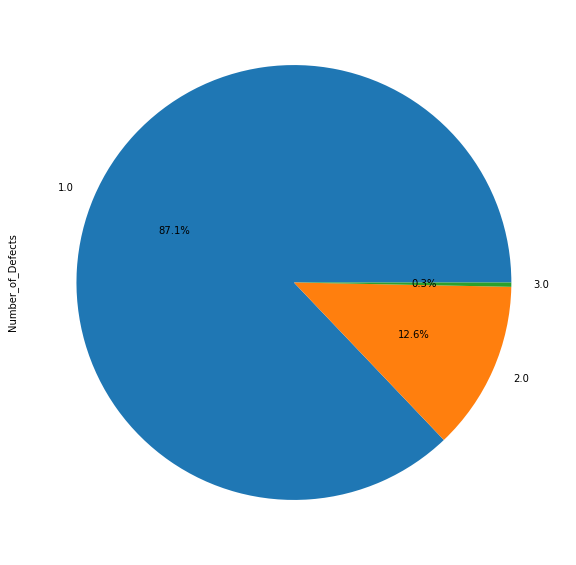

In [9]:
plt.figure(figsize=(10,10))
(df.groupby("Number_of_Defects")["Number_of_Defects"].sum()).plot.pie(autopct="%.1f%%");

From the above results it seems majority of the images have single type of defect but some have 2 types of defects and even some have 3 types of defects. But, samples with 3 types of defects are very less i.e only 0.3%.

Next let's draw a countplot of each defects.

In [10]:
cols = df.columns
cols = cols.drop('Name')
cols = cols.drop('Number_of_Defects')
dict1 = dict()
for ele in cols:
    dict1[ele] = df[ele].sum()

In [11]:
keys = list(dict1.keys())
vals = [int(dict1.get(k)) for k in keys]

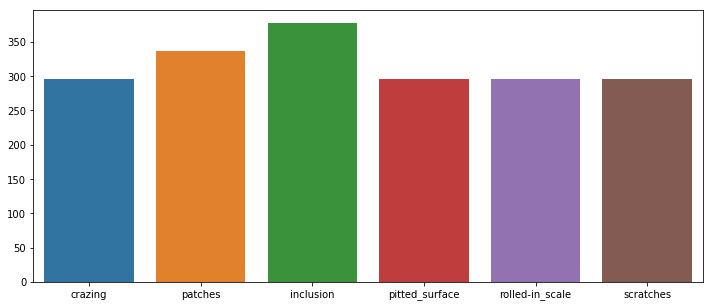

In [12]:
plt.figure(figsize=(12,5))
sns.barplot(x=keys, y=vals)

So, from the above result it seems that there are equal number of crazing, pitted_surface, rolled-in_scale and scratches on the samples. However, inclusion and patches are present more on the samples.

Next let's visualize some images of each class. For this we will write a function which will extract the mask from the annotation folder for an image. The mask returned by this function will be used to show the area of the defect on the image.

In [13]:
def make_mask(annot, labels):
    tree = ET.parse(annot)
    root = tree.getroot()
    #extract image  dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    masks = np.zeros((height, width, len(labels)), dtype=np.uint8) # float32 is V.Imp
        
    for idx, label in enumerate(labels):
        if labels.get(label) == 1:
            boxes = []
            for obj in root.findall('.//object'):
                if obj.find('name').text == label:                        
                    for box in obj.findall('.//bndbox'): 
                        xmin = int(box.find('xmin').text)
                        ymin = int(box.find('ymin').text)
                        xmax = int(box.find('xmax').text)
                        ymax = int(box.find('ymax').text)
                        coors = [xmin, ymin, xmax, ymax]
                        boxes.append(coors)    
                            
            mask = np.zeros((height, width), dtype=np.uint8)
            for i in range(len(boxes)):
                box = boxes[i]
                row_s, row_e = box[1], box[3]
                col_s, col_e = box[0], box[2]
                row_corr = [*range(row_s, row_e)]
                col_corr = [*range(col_s, col_e)]
                coords = np.array(list(product(row_corr, col_corr)))
                mask[coords[:,0], coords[:,1]] = 1
                    
            masks[:, :, idx] = mask.reshape(height, width, order='F')
         
    return masks

In [14]:
def show_mask_image(name, annot_folder, image_folder, labels):
    annot = "\\".join([annot_folder, (name+'.xml')])
    fname = "\\".join([image_folder, (name+'.jpg')])
    mask = make_mask(annot, labels)
    img = cv2.imread(fname) 
    fig, ax = plt.subplots(figsize=(5, 5))
    str1 = "This image has"
    str2 = "defect"
    multi = 0
    for ch in range(6):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        if len(contours) > 0:
            multi = multi + 1
            if multi > 1:
                str2 = str2 + ',' + defects[ch]
            else:
                str2 = defects[ch]
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    if multi == 0:
        str2 = "no defect"
    ax.set_title(name) 
    ax.set_xlabel(str1+" "+str2+".", fontsize=16)
    ax.imshow(img)
    plt.show()

Before we display the images we displayed the color palet for the defects.

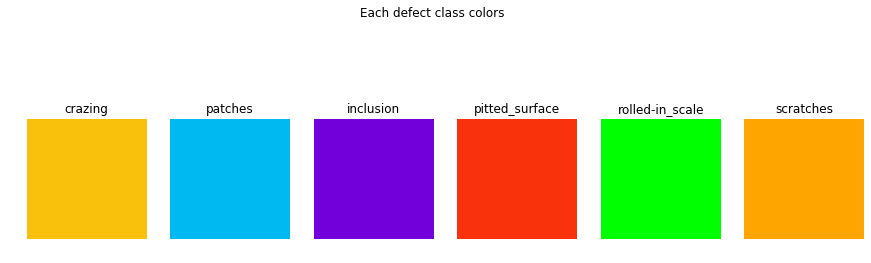

In [15]:
fig, ax = plt.subplots(1, 6, figsize=(15, 5))
defects = ["crazing","patches","inclusion","pitted_surface","rolled-in_scale","scratches"]
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12), (0,255,0), (255,165,0)]
for i in range(6):
    ax[i].axis('off')
    ax[i].imshow(np.ones((30, 30, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title(defects[i])
fig.suptitle("Each defect class colors")
plt.show()

Next we displayed the images which only had crazing.

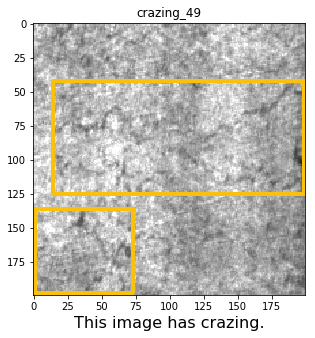

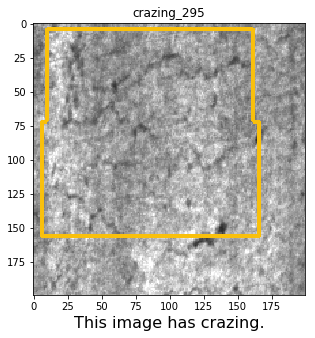

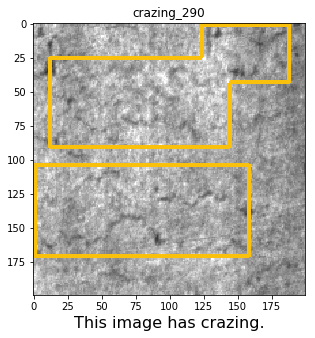

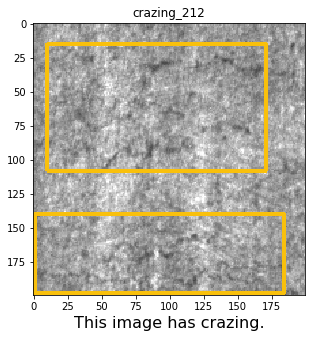

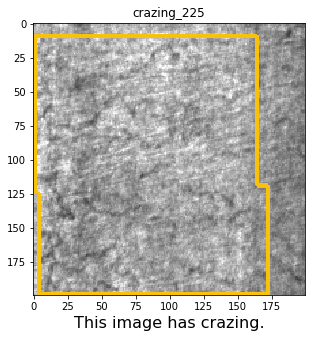

In [16]:
ls = df[(df['crazing'] == 1) & (df['Number_of_Defects'] == 1)]['Name'].sample(n=5).to_list()
for ele in ls:
    index = df[df['Name'] == ele].index
    for idx in index:
        labels = df.iloc[idx][1:7].to_dict()
        show_mask_image(ele, annot_folder, image_folder, labels)

Next we displayed images which only has inclusion.

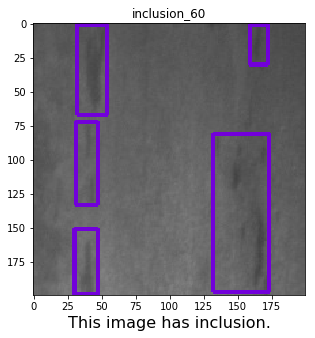

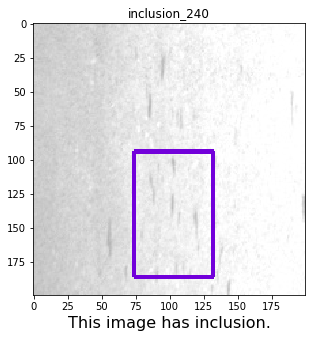

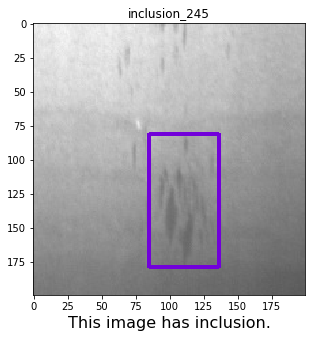

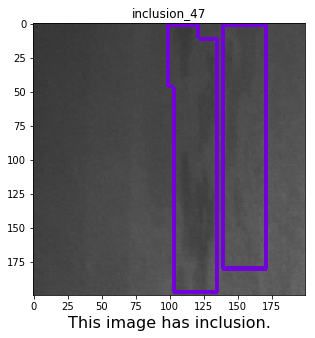

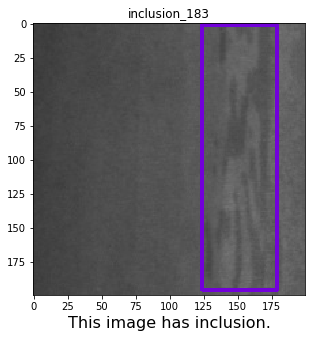

In [17]:
ls = df[(df['inclusion'] == 1) & (df['Number_of_Defects'] == 1)]['Name'].sample(n=5).to_list()
for ele in ls:
    index = df[df['Name'] == ele].index
    for idx in index:
        labels = df.iloc[idx][1:7].to_dict()
        show_mask_image(ele, annot_folder, image_folder, labels)

Next we displayed images which only had patches.

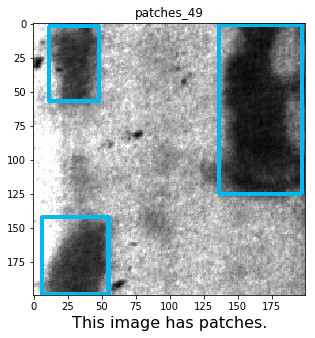

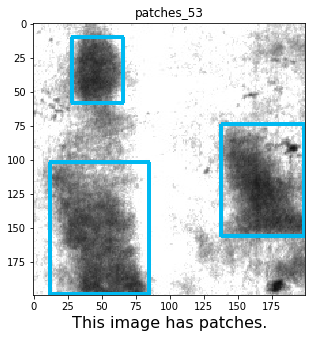

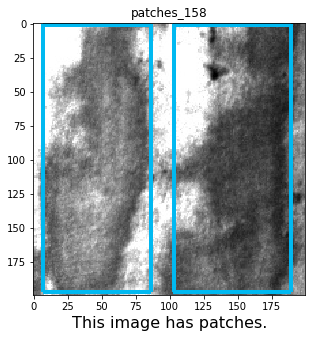

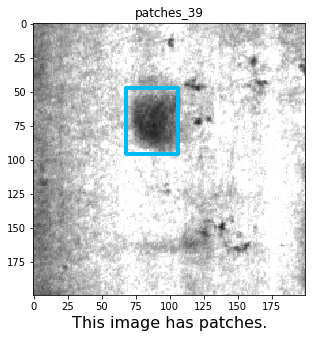

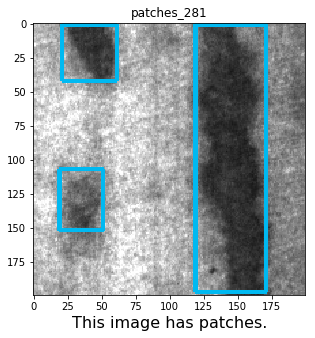

In [18]:
ls = df[(df['patches'] == 1) & (df['Number_of_Defects'] == 1)]['Name'].sample(n=5).to_list()
for ele in ls:
    index = df[df['Name'] == ele].index
    for idx in index:
        labels = df.iloc[idx][1:7].to_dict()
        show_mask_image(ele, annot_folder, image_folder, labels)

Next we displayed images which had pitted_surface.

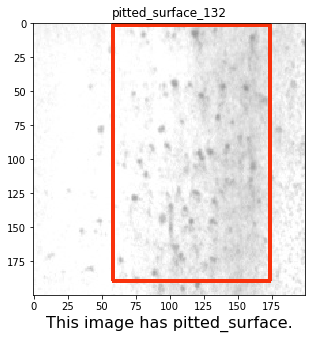

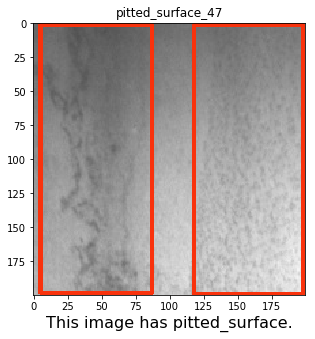

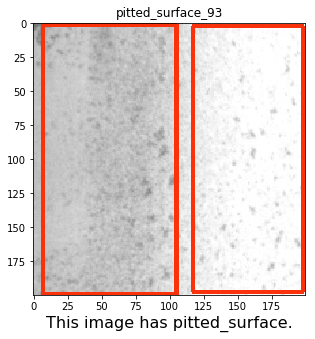

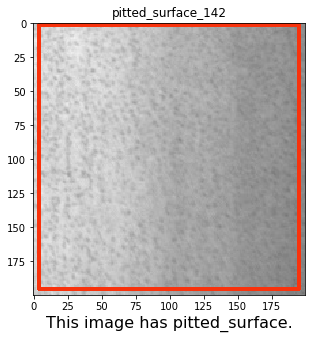

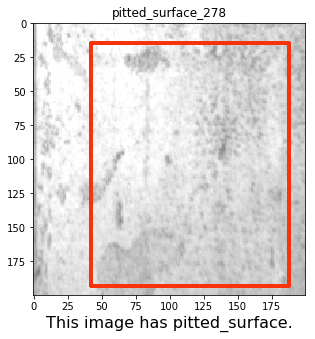

In [19]:
ls = df[(df['pitted_surface'] == 1) & (df['Number_of_Defects'] == 1)]['Name'].sample(n=5).to_list()
for ele in ls:
    index = df[df['Name'] == ele].index
    for idx in index:
        labels = df.iloc[idx][1:7].to_dict()
        show_mask_image(ele, annot_folder, image_folder, labels)

Next images with only rolled-in_scale were displayed.

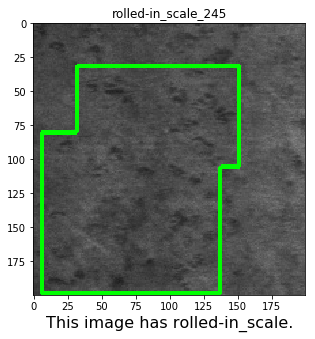

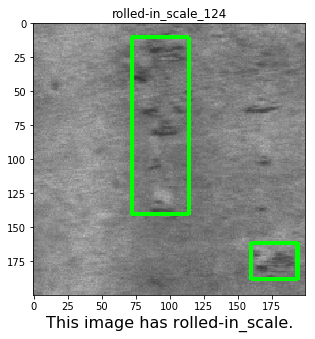

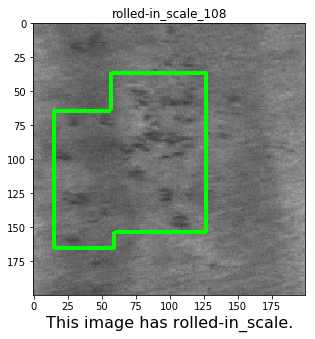

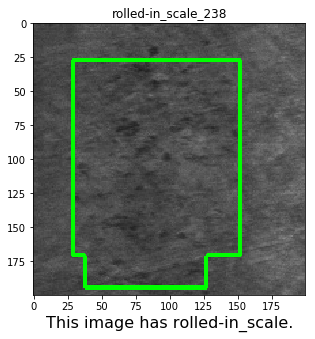

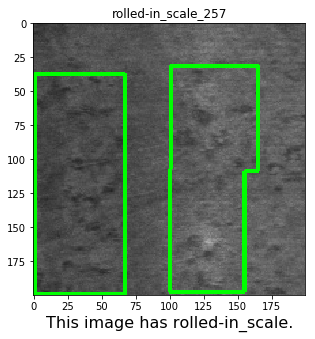

In [20]:
ls = df[(df['rolled-in_scale'] == 1) & (df['Number_of_Defects'] == 1)]['Name'].sample(n=5).to_list()
for ele in ls:
    index = df[df['Name'] == ele].index
    for idx in index:
        labels = df.iloc[idx][1:7].to_dict()
        show_mask_image(ele, annot_folder, image_folder, labels)

Next images with only scratches were displayed.

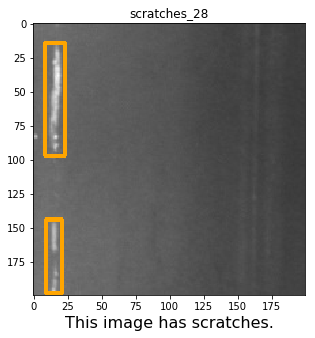

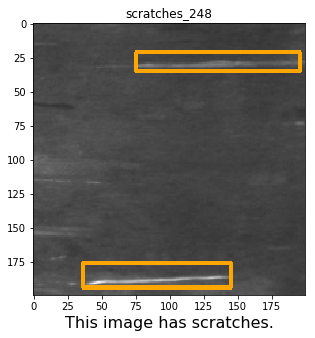

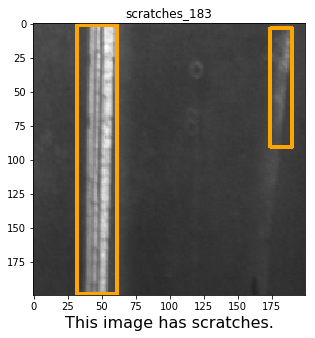

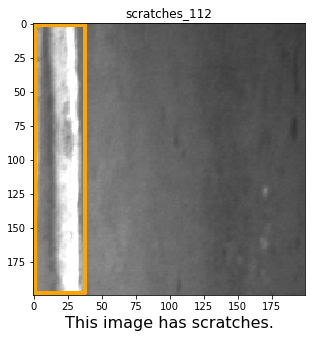

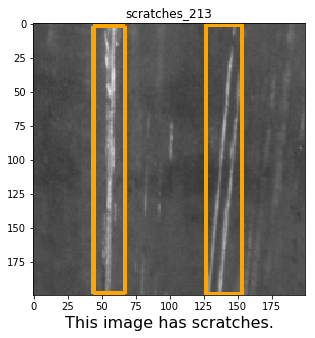

In [21]:
ls = df[(df['scratches'] == 1) & (df['Number_of_Defects'] == 1)]['Name'].sample(n=5).to_list()
for ele in ls:
    index = df[df['Name'] == ele].index
    for idx in index:
        labels = df.iloc[idx][1:7].to_dict()
        show_mask_image(ele, annot_folder, image_folder, labels)

Next images with 2 different types of defects were displayed.

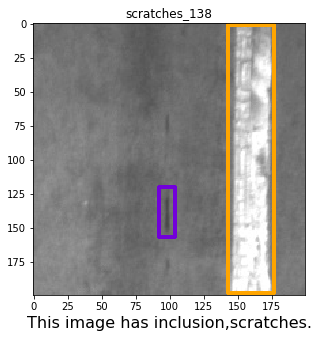

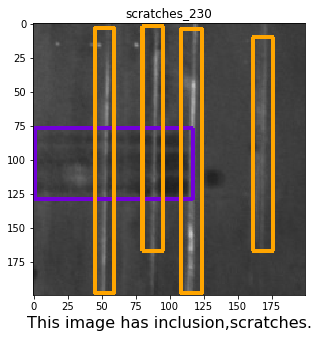

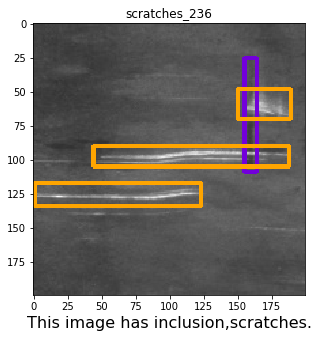

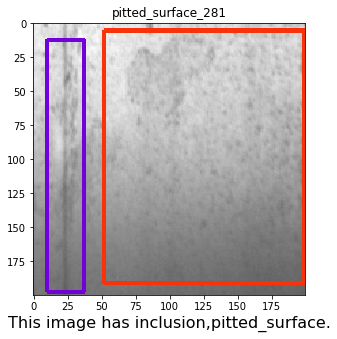

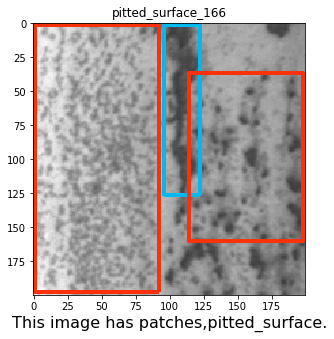

In [22]:
ls = df[df['Number_of_Defects'] == 2]['Name'].sample(n=5).to_list()
for ele in ls:
    index = df[df['Name'] == ele].index
    for idx in index:
        labels = df.iloc[idx][1:7].to_dict()
        show_mask_image(ele, annot_folder, image_folder, labels)

Lastly, images with 3 types of defects were displayed.

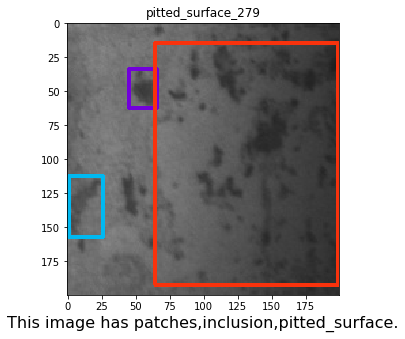

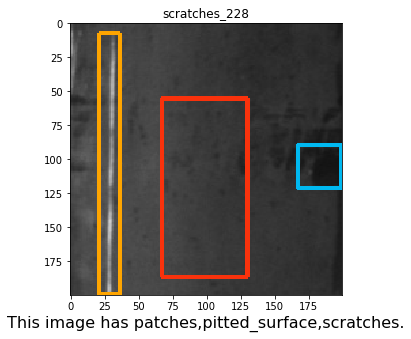

In [23]:
ls = df[df['Number_of_Defects'] == 3]['Name'].to_list()
for ele in ls:
    index = df[df['Name'] == ele].index
    for idx in index:
        labels = df.iloc[idx][1:7].to_dict()
        show_mask_image(ele, annot_folder, image_folder, labels)